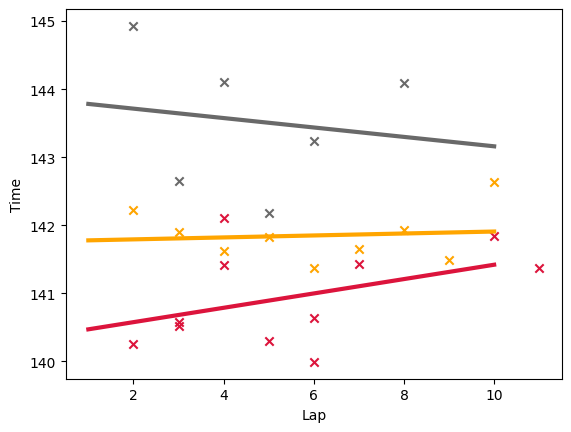

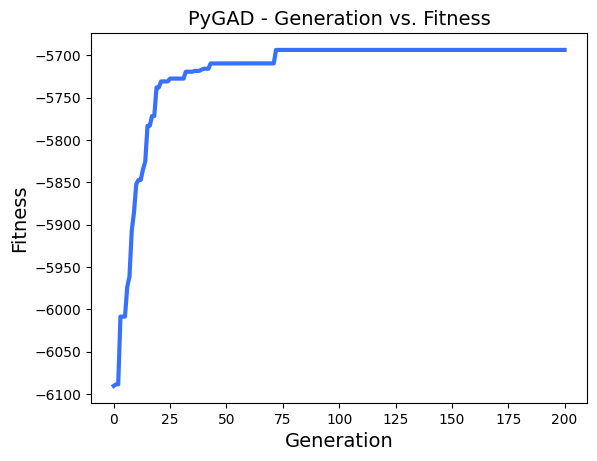

4 [[0, 10], [0, 10], [0, 10], [0, 10]] 5693.59978021978


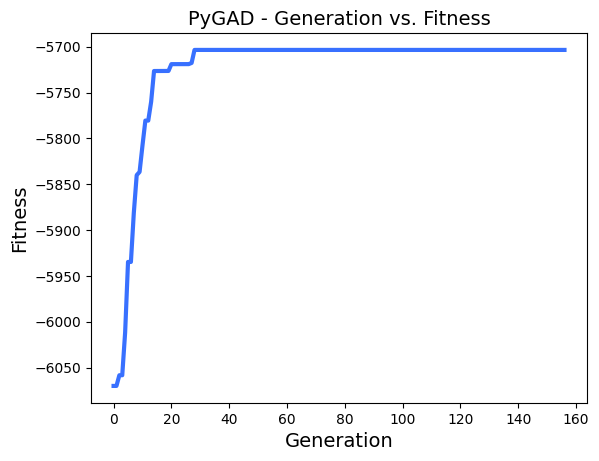

4 [[1, 10], [0, 10], [0, 10], [0, 10]] 5703.486057387057


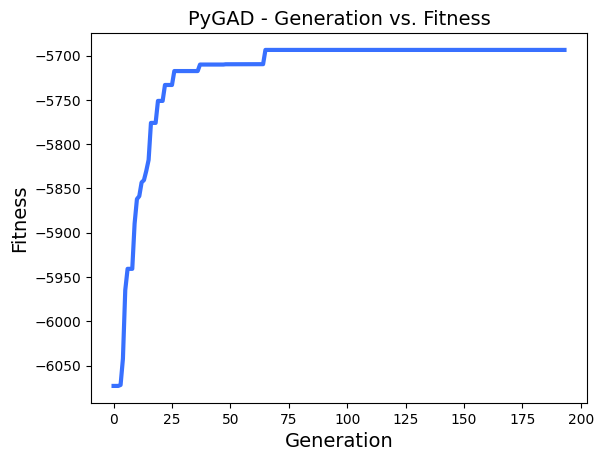

4 [[0, 10], [0, 10], [0, 10], [0, 10]] 5693.59978021978
done


In [27]:
import csv
from io import StringIO

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pygad


def _parse_lap_times(input):
    lap_times = {"RS": [], "RM": [], "RH": []}
    input = input.strip()
    for line in csv.DictReader(StringIO(input), delimiter='\t'):
        for compound in lap_times.keys():
            if time := line[compound]:
                lap_times[compound].append((int(line["Lap"]), float(time)))
    return lap_times


def _fit_linear_model(lap_data):
    lap_numbers = [[x] for x, _ in lap_data]
    lap_times = [y for _, y in lap_data]
    return LinearRegression().fit(lap_numbers, lap_times)


def _plot_model(lap_times, model, xlimit, color):
    plt.scatter(
        [[x] for x, _ in lap_times],
        [y for _, y in lap_times],
        marker="x",
        color=color
    )

    x = [[i] for i in range(1, xlimit + 1)]
    y = model.predict(x)
    plt.plot(x, y, color=color, linewidth=3)

    plt.xlabel("Lap")
    plt.ylabel("Time")


def _partition_stints(strategy):
    stints = [[strategy[0], 1]]
    for compound in strategy[1:]:
        if compound == -1:  # no tyre change
            stints[-1][1] += 1  # one more lap in current stint
        else:
            stints.append([compound, 1])
    return stints


assert _partition_stints([1, -1, -1, -1, -1, 2, -1, -1, -1, -1]) == [[1, 5], [2, 5]]
assert _partition_stints([1, -1, -1, 1, -1, -1, 1, -1, -1]) == [[1, 3], [1, 3], [1, 3]]
assert _partition_stints([1, 2, 3]) == [[1, 1], [2, 1], [3, 1]]
assert _partition_stints([1, -1, -1]) == [[1, 3]]


def _evaluate_strategy(stints, models, max_stint_length, pit_cost):
    if stints[0][0] == -1:  # must start on some tyres
        return float("inf")
    if any(stint_length > max_stint_length for _, stint_length in stints):
        return float("inf")
    time = 0
    for compound_id, stint_length in stints:
        compound = ("RS", "RM", "RH")[compound_id]
        x = [[i] for i in range(stint_length)]
        stint_time = sum(models[compound].predict(x))
        time += stint_time
    time += (len(stints) - 1) * pit_cost
    return time


def predict_top_strategies(
    data: str,
    *,
    lap_count: int,
    max_stint_length: int,
    pit_cost: float
):
    lap_times = _parse_lap_times(data)

    models = {
        compound: _fit_linear_model(data)
        for compound, data in lap_times.items()
        if data
    }

    for compound, model in models.items():
        colors = {"RS": "crimson", "RM": "orange", "RH": "dimgray"}
        _plot_model(lap_times[compound], model, max_stint_length, colors[compound])

    def fitness_function(ga_instance, solution, solution_idx):
        stints = _partition_stints(solution)
        # negate result so that the solution is minimized
        return -_evaluate_strategy(stints, models, max_stint_length, pit_cost)

    for i in range(3):
        ga_instance = pygad.GA(
            fitness_func=fitness_function,
            num_genes=lap_count,
            gene_type=int,
            gene_space=[-1, 0, 1, 2],
            num_generations=512,
            sol_per_pop=512,
            keep_elitism=64,
            stop_criteria="saturate_128",
            parent_selection_type="rank",
            num_parents_mating=8,
            crossover_type="two_points",
            mutation_type="scramble"
        )
        ga_instance.run()

        ga_instance.plot_fitness()
        best = ga_instance.best_solution()
        stints = _partition_stints(best[0])
        print(len(stints), stints, _evaluate_strategy(stints, models, max_stint_length, pit_cost))


    return ga_instance


# 0. Test - Spa 24h Layout
# Tx3; Fx5
# Duration: 90min ~ 39 laps


spa_test_data = """
Lap	RS	RM	RH
2		142.217	144.929
3	140.575	141.900	142.645
4	142.100	141.628	144.101
5		141.828	142.177
6	140.643	141.379	143.232
7	141.437	141.648
8		141.926	144.091
9		141.488
10	141.841	142.638
11	141.368
2	140.26
3	140.525
4	141.414
5	140.298
6	139.992
"""

result = predict_top_strategies(
    spa_test_data,
    lap_count=40,
    max_stint_length=10,
    pit_cost=20,  # guesstimate
)

print("done")